For representation purpose I have combined all the library 

In [ ]:
from pandas import read_csv
import pandas as pd
from pandas import set_option
import math
import time
import numpy as np
from numpy import set_printoptions
from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l1 
from keras.optimizers import Adam
from keras.losses import kullback_leibler_divergence
from keras.losses import mean_squared_error
from keras.models import Sequential 
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE , chi2
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from scipy.stats import uniform
from matplotlib import pyplot
import tensorflow as tf 
import random as python_random

### 1) Loading training and testing dataset

In [ ]:
# Loading the Training Data
filename = 'train_imperson_without4n7_balanced_data.csv'
train_dataframe = read_csv(filename)
array = train_dataframe.values
# separate array into input and output components
X = array[:,0:152]
Y = array[:,152]

In [ ]:
# Loading the Testing Data
filename = 'test_imperson_without4n7_balanced_data.csv'
test_dataframe = read_csv(filename)
array = test_dataframe.values
# separate array into input and output components
X_t = array[:,0:152]
Y_t = array[:,152]

### 1) (a) Data Description 

In [ ]:
set_option('display.width', 100)
set_option('precision', 3)
description_train = train_dataframe.describe()
description_train

,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155
count,97044.0,97044.0,97044.0,9.704e+04,9.704e+04,97044.000,97044.000,97044.0,97044.0,97044.0,97044.0,97044.000,97044.000,97044.000,97044.0,97044.000,97044.0,97044.000,97044.0,97044.0,97044.0,97044.0,97044.0,97044.000,97044.0,97044.0,97044.000,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.000,97044.0,97044.0,97044.0,97044.0,...,97044.0,9.704e+04,97044.000,9.704e+04,97044.000,9.704e+04,9.704e+04,9.704e+04,97044.0,9.704e+04,9.704e+04,9.704e+04,9.704e+04,9.704e+04,97044.000,97044.0,97044.0,9.704e+04,97044.0,97044.0,97044.0,97044.0,97044.000,97044.0,97044.000,97044.000,97044.000,97044.000,9.704e+04,97044.000,97044.000,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.000,97044.0
mean,0.0,0.0,0.0,6.252e-03,6.252e-03,0.194,0.194,0.0,0.0,0.0,0.0,1.000,1.000,1.000,1.0,1.000,0.0,1.000,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714,0.0,0.0,0.0,0.0,...,0.0,6.494e-06,0.090,3.359e-04,0.037,2.127e-05,1.823e-04,6.183e-04,0.0,4.944e-04,3.317e-07,1.690e-04,6.422e-07,3.403e-07,0.022,0.0,0.0,1.030e-05,0.0,0.0,0.0,0.0,0.500,1.0,0.273,0.004,0.261,0.006,3.463e-04,0.028,0.028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178,0.5
std,0.0,0.0,0.0,1.554e-02,1.554e-02,0.354,0.354,0.0,0.0,0.0,0.0,0.015,0.015,0.015,0.0,0.015,0.0,0.015,0.0,0.0,0.0,0.0,0.0,0.015,0.0,0.0,0.015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110,0.0,0.0,0.0,0.0,...,0.0,9.109e-04,0.286,1.152e-02,0.126,3.109e-04,9.980e-04,2.486e-02,0.0,1.273e-02,2.236e-06,1.139e-03,4.367e-06,2.294e-06,0.145,0.0,0.0,3.210e-03,0.0,0.0,0.0,0.0,0.001,0.0,0.260,0.036,0.262,0.060,1.331e-02,0.063,0.063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360,0.5
min,0.0,0.0,0.0,2.860e-06,2.860e-06,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,1.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.000e+00,0.000,0.000e+00,0.000,0.000e+00,0.000e+00,0.000e+00,0.0,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.500,1.0,0.000,0.000,0.000,0.000,0.000e+00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
25%,0.0,0.0,0.0,1.442e-03,1.442e-03,0.038,0.038,0.0,0.0,0.0,0.0,1.000,1.000,1.000,1.0,1.000,0.0,1.000,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.654,0.0,0.0,0.0,0.0,...,0.0,0.000e+00,0.000,0.000e+00,0.000,0.000e+00,0.000e+00,0.000e+00,0.0,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.500,1.0,0.000,0.000,0.000,0.000,0.000e+00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
50%,0.0,0.0,0.0,3.706e-03,3.706e-03,0.038,0.038,0.0,0.0,0.0,0.0,1.000,1.000,1.000,1.0,1.000,0.0,1.000,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.757,0.0,0.0,0.0,0.0,...,0.0,0.000e+00,0.000,0.000e+00,0.000,0.000e+00,0.000e+00,0.000e+00,0.0,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.500,1.0,0.326,0.000,0.201,0.000,0.000e+00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024,0.5
75%,0.0,0.0,0.0,5.916e-03,5.916e-03,0.055,0.055,0.0,0.0,0.0,0.0,1.000,1.000,1.000,1.0,1.000,0.0,1.000,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.768,0.0,0.0,0.0,0.0,...,0.0,0.000e+00,0.000,0.000e+00,0.000,0.000e+00,0.000e+00,0.000e+00,0.0,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.500,1.0,0.447,0.000,0.418,0.000,0.000e+00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024,1.0
max,0.0,0.0,0.0,9.784e-01,9.784e-01,1.000,1.000,0.0,0.0,0.0,0.0,1.000,1.000,1.000,1.0,1.000,0.0,1.000,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.934,0.0,0.0,0.0,0.0,...,0.0,1.561e-01,1.000,9.948e-01,1.000,4.566e-03,7.936e-03,1.000e+00,0.0,3.333e-

In [ ]:
set_option('display.width', 100)
set_option('precision', 3)
description_test = test_dataframe.describe()
description_test

,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155
count,40158.0,40158.0,40158.0,4.016e+04,4.016e+04,40158.000,40158.000,40158.0,40158.0,40158.0,40158.0,40158.000,40158.000,40158.000,40158.0,40158.000,40158.0,40158.000,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000,40158.0,40158.0,40158.000,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000,40158.0,40158.0,40158.0,40158.0,...,40158.0,40158.0,40158.000,40158.000,40158.000,40158.000,40158.000,40158.000,40158.0,40158.000,40158.000,40158.000,40158.000,40158.000,40158.000,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000,40158.000,40158.000,40158.000,40158.000,40158.000,40158.000,40158.0,4.016e+04,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000,40158.0
mean,0.0,0.0,0.0,5.080e-03,5.080e-03,0.201,0.201,0.0,0.0,0.0,0.0,1.000,1.000,1.000,1.0,1.000,0.0,1.000,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.944,0.0,0.0,0.0,0.0,...,0.0,0.0,0.095,0.001,0.044,0.004,0.020,0.001,0.0,0.004,0.031,0.016,0.030,0.031,0.031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122,0.045,0.196,0.009,0.005,0.028,0.028,0.0,2.490e-05,0.0,0.0,0.0,0.0,0.0,0.185,0.5
std,0.0,0.0,0.0,1.619e-02,1.619e-02,0.371,0.371,0.0,0.0,0.0,0.0,0.017,0.017,0.017,0.0,0.017,0.0,0.017,0.0,0.0,0.0,0.0,0.0,0.017,0.0,0.0,0.017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040,0.0,0.0,0.0,0.0,...,0.0,0.0,0.294,0.005,0.135,0.042,0.096,0.036,0.0,0.061,0.174,0.087,0.167,0.174,0.174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.115,0.310,0.077,0.033,0.063,0.063,0.0,4.990e-03,0.0,0.0,0.0,0.0,0.0,0.378,0.5
min,0.0,0.0,0.0,5.810e-06,5.810e-06,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,1.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,0.000,0.0
25%,0.0,0.0,0.0,1.362e-03,1.362e-03,0.017,0.017,0.0,0.0,0.0,0.0,1.000,1.000,1.000,1.0,1.000,0.0,1.000,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.906,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,0.003,0.0
50%,0.0,0.0,0.0,2.262e-03,2.262e-03,0.017,0.017,0.0,0.0,0.0,0.0,1.000,1.000,1.000,1.0,1.000,0.0,1.000,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.967,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,0.003,0.5
75%,0.0,0.0,0.0,3.163e-03,3.163e-03,0.060,0.060,0.0,0.0,0.0,0.0,1.000,1.000,1.000,1.0,1.000,0.0,1.000,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.976,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028,0.000,0.370,0.000,0.000,0.000,0.000,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,0.040,1.0
max,0.0,0.0,0.0,9.048e-01,9.048e-01,1.000,1.000,0.0,0.0,0.0,0.0,1.000,1.000,1.000,1.0,1.000,0.0,1.000,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.978,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000,0.162,0.923,0.500,0.667,1.000,0.0,1.000,1.000,0.500,1.000,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,1.000,1.000,0.976,0.391,1.000,1.000,0.0,1.000e+00,0.0,0.0,0.0,0.0,0.0,1.000,1.0


### 2) Normalizing the training and testing dataset

In [ ]:
# Here we normilize the the New traning dataset (with 162 features)
train_scaler = Normalizer().fit(X) 
train_normalizedX = train_scaler.transform(X) 

In [ ]:
# Here we normilize the the New traning dataset (with 162 features)
test_normalizedX = train_scaler.transform(X_t) 

### 3) Applying Autoencoder on the new normilized Training and Testing data to get the 10 additional features

In [ ]:
# Applying Autoencoder on normilized Training data set
input_size = 152
hidden_size= 50
code_size = 10
input_dat= Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_dat)
code = Dense(code_size, activation='relu', activity_regularizer=l1(10e-6))(hidden_1)
encoder = Model(input_dat, code)
encoded_train_vals = encoder.predict(train_normalizedX)

In [ ]:
# Applying Autoencoder on normilized Testing data set
encoded_test_vals = encoder.predict(test_normalizedX)

In [ ]:
# To check the encoder output of 10 features for normilized Training dataset 
encoded_train_vals.shape

(97044, 10)

In [ ]:
# To check the encoder output of 10 features for normilized Testing dataset
encoded_test_vals.shape

(40158, 10)

### 4) Adding the 10 new features acquired from the normilized Training and Testing dataset and combining these features with the normilized training and testing datasets to acquiring 162 features in both of them.

In [ ]:
# To add the 10 new Training features in the Normalized Training data set X 
Train_array1 = np.array(train_normalizedX)
Train_array2 = np.array(encoded_train_vals)
Train_array_X = np.concatenate((Train_array1, Train_array2), axis=1)

In [ ]:
Train_array_X.shape

(97044, 162)

In [ ]:
# To add the 10 new Testing features in the Normalized Testing data set X_t 
Test_array1 = np.array(test_normalizedX)
Test_array2 = np.array(encoded_test_vals)
Test_array_X = np.concatenate((Test_array1, Test_array2), axis=1)

In [ ]:
Test_array_X.shape

(40158, 162)

### 5) Now we will used Filter, Wrapper and Embeded method for Feature selection. To select the best features in the new test and train dataset with 162 features. 

### (a) Filter method - using SelectKBest :

In [ ]:
#Select k best on train set 
selectModel = SelectKBest(score_func=chi2, k=50)
kBesttrain = selectModel.fit(Train_array_X,Y)
selectTrainFeatures = kBesttrain.transform(Train_array_X)

In [ ]:
#Select k best on test set 
selectTestFeatures = kBesttrain.transform(Test_array_X)

In [ ]:
selectTrainFeatures.shape

(97044, 50)

In [ ]:
selectTestFeatures.shape

(40158, 50)

### (b) Wrapper method - using Recursive feature elimination (RFE)

In [ ]:
#RFE on train set
model_rfe = LogisticRegression(solver='liblinear') 
rfeModel = RFE(model_rfe, 50) 
rfeTrain = rfeModel.fit(Train_array_X,Y)
rfeTrainFeatures = rfeTrain.transform(Train_array_X)

In [ ]:
rfeTrainFeatures.shape

(97044, 50)

In [ ]:
#RFE on test set
rfeTestFeatures = rfeTrain.transform(Test_array_X)

In [ ]:
rfeTestFeatures.shape

(40158, 50)

### (c) Embedded method - using ExtraTreesClassifier

In [ ]:
#ExtraTree on train set
extraTreeModel = ExtraTreesClassifier(n_estimators=50)
exTreeTrain = extraTreeModel.fit(Train_array_X, Y)
clf_model = SelectFromModel(exTreeTrain, prefit=True)
exTreeTrainFeatures = clf_model.transform(Train_array_X)

In [ ]:
exTreeTrainFeatures.shape

(97044, 37)

In [ ]:
#ExtraTree on test set
exTreeTestFeatures = clf_model.transform(Test_array_X)

In [ ]:
exTreeTestFeatures.shape

(40158, 37)

### 6) Now we will do the Feature Reduction by using Principal component Analysis (PCA) from the output of Filter (SelectKBest)

###Note: We had implimented the output of wrapper (RFE) and embedded (extratree classifier) but the best results were found by using filter (Selectkbest) method. 

In [ ]:
# On selected train feature dataset for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# feature extraction
pca = PCA(n_components=10, random_state = 7)  #this is used to transform the dataset in to 10 attributes
fit_pca_train = pca.fit(selectTrainFeatures) # this is used to judge the paramaters of X
pca_train_features = fit_pca_train.transform(selectTrainFeatures)

In [ ]:
## On selected test feature dataset for PCA # 
pca_test_features = fit_pca_train.transform(selectTestFeatures)

In [ ]:
pca_train_features.shape

(97044, 10)

In [ ]:
pca_test_features.shape

(40158, 10)

### Building (Model Training) and Comparing Models

### 7) Evaulate performance of models (using GridsearchCV) like 
(a) Deep Learning model using Keras

(b) Logistic regression 

(c) K - Nearest neighbor (KNN)

(d) Linear SVM

(e) Random Forest



### (a) Deep learning model with Keras

In [ ]:
# Grid Search Deep Learning Model Parameters
# create a function to build a model, required for KerasClassifier

optimizers = ['adam', 'rmsprop']
inits = ['uniform', 'glorot_uniform'] 
epochs = [5, 7, 10]
batches = [20, 30, 40]

# Custom Loss funtion
def custom_loss(y_true, y_pred):
    alpha = 7
    beta = 3
    loss_mean = tf.keras.losses.mean_squared_error(y_true, y_pred)
    loss_binary = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    loss_KL = tf.keras.losses.kullback_leibler_divergence(y_true, y_pred)
    loss = loss_mean+(alpha*loss_binary)+(beta*loss_KL)
    return loss

def create_model(optimizer=optimizers, init=inits):
  # create model
  mlp_model = Sequential()
  mlp_model.add(Dense(12, input_dim=10, activation='relu')) 
  mlp_model.add(Dense(10, activation='relu')) 
  mlp_model.add(Dense(1, activation='sigmoid'))

  # Compile model
  mlp_model.compile(loss = custom_loss, metrics=["accuracy"])
  return mlp_model

# create model
model_keras = KerasClassifier(build_fn=create_model, verbose=0)

# grid search epochs, batch size and optimizer
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits) 
grid = GridSearchCV(estimator=model_keras, param_grid=param_grid)
grid_result = grid.fit(pca_train_features,Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 

Best: 0.970137 using {'batch_size': 40, 'epochs': 7, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}


### (b) Logistic regression

In [ ]:
from sklearn.model_selection import GridSearchCV
solvers = ['lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100,10, 1.0, 0.1, 0.01]
param_grid = dict(solver=solvers,penalty=penalty,C=c_values)
model = LogisticRegression(max_iter=2000)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(pca_train_features, Y)
print(grid.best_score_)
print(grid.best_estimator_)

0.9683431260397679
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


### (c) K - Nearest neighbor (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
n_neighbors = range(10, 15, 5)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
param_grid_NB = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_NB, n_jobs=-1)
grid_result = grid_search.fit(pca_train_features, Y)
print(grid_result.best_score_)
print(grid_result.best_estimator_)

0.9931059983476274
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')


### (d) Linear SVM

In [ ]:
model = SVC()
kernel = ['linear']
C = [1.0, 0.1, 0.01]
gamma = ['scale']
grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_search_SVM = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1)
grid_result_SVM = grid_search_SVM.fit(pca_train_features, Y)
print(grid_result_SVM.best_score_)
print(grid_result_SVM.best_estimator_)

0.942601262717252
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### (e) Naive Bayes Classifier

In [ ]:
param_grid = {}
model = GaussianNB() 
grid = GridSearchCV(estimator=model, param_grid = param_grid)
grid.fit(pca_train_features, Y)
print(grid.best_score_)
print(grid.best_estimator_)

0.9517936107398184
GaussianNB(priors=None, var_smoothing=1e-09)


###8) Comparing best models :

(a) Using Crossvalidation on hyperparameter tuned models and compare the performance accuracy



LR: 0.988541 (0.001213)
KNN: 0.998887 (0.000414)
SVM: 0.982379 (0.001111)
NB,: 0.955680 (0.002946)
Epoch 1/10
2912/2912 [==============================] - 4s 1ms/step - loss: 0.3230 - accuracy: 0.9505
Epoch 2/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0335 - accuracy: 0.9899
Epoch 3/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0311 - accuracy: 0.9906
Epoch 4/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0289 - accuracy: 0.9908
Epoch 5/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0280 - accuracy: 0.9911
Epoch 6/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0261 - accuracy: 0.9920
Epoch 7/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0263 - accuracy: 0.9920
Epoch 8/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0260 - accuracy: 0.9923
Epoch 9/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0237 - 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
2912/2912 [==============================] - 4s 1ms/step - loss: 0.3080 - accuracy: 0.9404
Epoch 2/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0379 - accuracy: 0.9897
Epoch 3/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0346 - accuracy: 0.9899
Epoch 4/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0327 - accuracy: 0.9905
Epoch 5/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0295 - accuracy: 0.9915
Epoch 6/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0279 - accuracy: 0.9920
Epoch 7/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0276 - accuracy: 0.9922
Epoch 8/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0284 - accuracy: 0.9923
Epoch 9/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.0247 - accuracy: 0.9930
Epoch 10/10
2912/2912 [==============================] - 3s 1ms/step - loss: 0.026

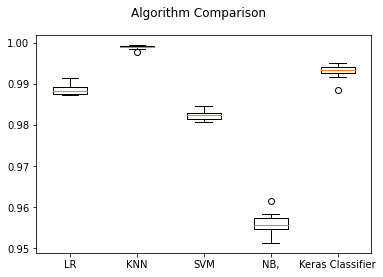

In [ ]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear',penalty='l2',C=100, max_iter=2000)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=10,metric='euclidean',weights='uniform')))
models.append(('SVM', SVC(kernel='linear', C=1.0, gamma='scale')))
models.append(('NB,', GaussianNB(priors=None, var_smoothing=1e-09)))
models.append(('Keras Classifier', KerasClassifier(build_fn=create_model, batch_size= 40, epochs= 7)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=10, random_state=7,shuffle=True)
  cv_results = cross_val_score(model, pca_train_features, Y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()


### (b) Predicting labels of test data instances and evaluating model based on :

###(i) Time taken to build model

###(ii) Time taken to test model

###(iii) Model Accuracy 

###(iv) Model Error Rate

###(v) DetectionRate

###(vi) False Positive/Alarm

###(vii) Matthews correlation coefficient (MCC)


In [ ]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear',penalty='l2',C=100, max_iter=2000, random_state=0)))
models.append(('K - Nearest neighbor (KNN)', KNeighborsClassifier(n_neighbors=10,metric='euclidean',weights='uniform')))
models.append(('Linear SVM', SVC(kernel='linear', C=1.0, gamma='scale', random_state=0)))
models.append(('Naive Bayes Classifier', GaussianNB(priors=None, var_smoothing=1e-09)))
models.append(('Keras Classifier', KerasClassifier(build_fn=create_model, batch_size= 40, epochs= 7, init = 'glorot_uniform', optimizer='rmsprop')))


for name, model in models:
  print("-----------------------------------------------")
  print("Model : ", name)
  model_start = time.time()
  model.fit(pca_train_features, Y)
  print("Time to build model (sec) : %.4f " % round(time.time()-model_start,4))
  start = time.time()
  predicted = model.predict(pca_test_features)
  print("Time to test model (sec) : %.4f " % round(time.time()-start,4))
  matrix = confusion_matrix(Y_t, predicted)
  print("Time elapsed (sec): %.4f " % round(time.time()-model_start, 4))
  print(matrix)

  TN1 = matrix[0][0]
  FN1 = matrix[1][0]
  FP1 = matrix[0][1]
  TP1 = matrix[1][1]

  DetectionRate_LR = TP1/(TP1+FN1)
  Alarm_LR =   FP1/(FP1+TN1)

  # To built a MCC for LR
  MCC_num_LR= (TP1*TN1)-(FP1*FN1) 
  MCC_din_LR= math.sqrt((TP1 + FP1)*(TP1+FN1)*(TN1 + FP1)*(TN1+FN1))

  MCC_LR = MCC_num_LR / MCC_din_LR
  Acc_LR = (TP1 + TN1) / (TP1+FP1+FN1+TN1)
  Err_LR = 1 - Acc_LR
  print("Model Accuracy : %s"%(Acc_LR))
  print("Model Error Rate : %s"%(Err_LR))
  print("DetectionRate :%s"%(DetectionRate_LR))
  print("False Positive/Alarm :%s"%(Alarm_LR))
  print("Matthews correlation coefficient (MCC):%s"%(MCC_LR))
  


-----------------------------------------------
Model :  Logistic Regression
Time to build model (sec) : 0.2251 
Time to test model (sec) : 0.0023 
Time elapsed (sec): 0.3018 
[[19239   840]
 [  396 19683]]
Model Accuracy : 0.9692215747796205
Model Error Rate : 0.030778425220379546
DetectionRate :0.9802779022859704
False Positive/Alarm :0.041834752726729416
Matthews correlation coefficient (MCC):0.9386726687779009
-----------------------------------------------
Model :  K - Nearest neighbor (KNN)
Time to build model (sec) : 0.1837 
Time to test model (sec) : 2.0728 
Time elapsed (sec): 2.2867 
[[19967   112]
 [18651  1428]]
Model Accuracy : 0.5327705563026047
Model Error Rate : 0.4672294436973953
DetectionRate :0.07111907963544001
False Positive/Alarm :0.005577967030230589
Matthews correlation coefficient (MCC):0.17064777880156473
-----------------------------------------------
Model :  Linear SVM
Time to build model (sec) : 39.9580 
Time to test model (sec) : 4.2119 
Time elapsed (sec

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Time to test model (sec) : 0.7704 
Time elapsed (sec): 37.3929 
[[19695   384]
 [18644  1435]]
Model Accuracy : 0.5261716220927337
Model Error Rate : 0.4738283779072663
DetectionRate :0.07146770257482943
False Positive/Alarm :0.01912445838936202
Matthews correlation coefficient (MCC):0.12585369653296963
